In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
from tqdm import tqdm
import os

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking, Concatenate
from sklearn.model_selection import KFold

2024-06-04 23:13:42.526686: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
sys.path.append('../External_Functions')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH, simpson38
from ExternalFunctions import nice_string_output, add_text_to_ax 

In [4]:
from PlotUtils import getColour, setMplParam, getHistoParam, getHistoParamWithBinWidth

In [5]:
setMplParam(10)

In [6]:
def readNFLPlay():
    subDirPath = '../NFLPlay/'
    plays = pd.read_csv(subDirPath+'plays.csv')
    return plays

In [7]:
NFLplays_raw = readNFLPlay()
# 50 sec on Cyan's pc
# 20 sec on Cyan's laptop

In [8]:
NFLplays_raw['gameId'].dtype

dtype('int64')

## the columns

In [9]:
NFLplays_raw.shape

(870384, 44)

In [10]:
indices = ['playId', 'gameId']

playCircumstance = ['playSequence', 
                'quarter', 
                'possessionTeamId',
                'nonpossessionTeamId', 
                'playNumberByTeam',
                'gameClock', 
                'down', 
                'distance',
                'distanceToGoalPre',
                'netYards',
                'scorePossession',
                'scoreNonpossession',
                'fieldGoalProbability',]

# classification
playType = ['playType',
            'huddle',
            'formation']

playResult = ['playResult',
                'gameClockSecondsExpired',
              'gameClockStoppedAfterPlay', 
               'noPlay', # is the play a penalty
               'offensiveYards',
               ]

playSubsequence = ['isClockRunning', 
                        'changePossession', 
                        'turnover',
                        'safety',
                        'firstDown',]

idk = [ 'typeOfPlay',
        'fourthDownConversion',
        'thirdDownConversion',
        'homeScorePre', 
        'visitingScorePre',
        'homeScorePost',
        'visitingScorePost',
        'distanceToGoalPost']

# the original dataset has 3 columns of their own prediction of the play we may be able to use them as a reference
reference = ['evPre',
             'evPost', 
             'evPlay',]

exclude = [ 'playTypeDetailed', # redundant to playType2
            'fieldPosition', 
            'playDescription',
            'playStats',
            'playDescriptionFull', 
            'efficientPlay']

# Data Analysis Algorithm
1. playCircumstance -> XGB -> playType
2. playCircumstance & playType -> Regression (NN?XGB?) -> playResult
3. playResult -> **manual function** -> playCircumstance
<!-- * updateCircumstance -->

# Data Preprocessing

In [11]:
import Preprocess as pp

### <span style="color:red">runPreprocess</span> 
this is where the collective preprocessing algorithms come into play!

In [12]:
NFLplays = pp.runPreprocess(NFLplays_raw, exclude, idk)
# 8 sec on Cyan's laptop

In [13]:
NFLplays.columns

Index(['playId', 'gameId', 'playSequence', 'quarter', 'possessionTeamId',
       'nonpossessionTeamId', 'playType', 'playNumberByTeam', 'gameClock',
       'gameClockSecondsExpired', 'gameClockStoppedAfterPlay', 'down',
       'distance', 'distanceToGoalPre', 'noPlay', 'changePossession',
       'turnover', 'safety', 'offensiveYards', 'netYards', 'firstDown',
       'evPre', 'evPost', 'evPlay', 'scorePossession', 'scoreNonpossession',
       'fieldGoalProbability', 'huddle', 'formation', 'playResult'],
      dtype='object')

In [14]:
NFLplays.shape

(870384, 30)

### ~~Classification using XGB~~
* ~~due to heavy computational cost, use `fraction` to sample some of the whole data~~
* ~~if too small fraction of data are used, it returns an error~~

|fraction| time taken| hh : mm |
|--------|-----------|---------|
|1.0     |485 min    | 08 : 05 |
|0.33    |152 min    | 02 : 32 |
|0.1     |42 min     | 00 : 42 |

In [15]:
# import Classification as clf
# FRACTION = 1.0
# analysisSampleSize = int(NFLplays.shape[0]*FRACTION)
# print(f'Analysis Sample Size: {analysisSampleSize}')
# print(f'Fraction string tag: {clf.convertFractionIntoString(FRACTION)}')
# runPlayTypeClassification(NFLplays, FRACTION, 5)
# 1.0 : 485 min : 8 hr 5 min
# 0.33: 152 min : 2 hr 32 min
# 0.1 : 42 min : 0.7 hr

1. data preprocessing
2. data division: playCircumstance, playType, playResult
3. XGB classification using play circumstance to predict play type.
4. combination of play circumstance and the predicted play type
5. regression using the combined data for get play result
6. define a function that takes the play result as one of its arguments and returns updated play circumstance
7. repeat (3)-(6)

### Discussion on 29 May 2024 Wednesday Afternoon
1. We may be able to use a RNN algorithm directly.
   * ### **GRU? LSTM?**
2. In that case, we don't need classification
3. The whole data will be given to the model
4. The data will be divided into game-wise
   * it was confirmed the data contains plays from 5308 games

* `NFLplays_split`: Game-wise slitted data

In [16]:
NFLplays_split = pp.getSplittedList(NFLplays)
# 18.8sec

In [17]:
print(f'Number of columns: {len(NFLplays.columns)}')

Number of columns: 30


In [18]:
print(f'Number of games: {len(NFLplays_split)}')

Number of games: 5308


In [19]:
print(f'Number of plays in the first game: {len(NFLplays_split[0])}')
print(f'Number of plays in the second game: {len(NFLplays_split[1])}')
print(f'Number of plays in the third game: {len(NFLplays_split[2])}')

Number of plays in the first game: 164
Number of plays in the second game: 162
Number of plays in the third game: 170


In [20]:
# NFLplays_split[0].head()

In [21]:
# NFLplays_split[0].tail()

In [22]:
def plotHistPlaySequences(NFLplays_split):
    sequences = np.zeros(len(NFLplays_split))
    for i in range(len(NFLplays_split)):
        sequences[i] = len(NFLplays_split[i])
    Nbins, binwidth, counts, x_centres = getHistoParam(sequences)
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.hist(sequences, bins=Nbins, histtype='step', hatch='/')
    ax.set_xlabel('Number of plays in a game')
    ax.set_ylabel('Counts')
    ax.set_title('Number of plays in a game')
    
    d = {'N' : len(sequences),
        'mean' : f'{np.mean(sequences):.2f}',
        'median' : f'{int(np.median(sequences))}',
        'max' : f'{int(np.max(sequences))}',
        'min' : f'{int(np.min(sequences))}',
        'std' : f'{np.std(sequences):.2f}',
        '25%' : f'{int(np.percentile(sequences, 25))}',
        '75%' : f'{int(np.percentile(sequences, 75))}',
        'N bins' : f'{Nbins:d}',
        'bin width' : f'{binwidth:.2f}',
        }
    add_text_to_ax(0.05, 0.95, nice_string_output(d), ax, fontsize=12)

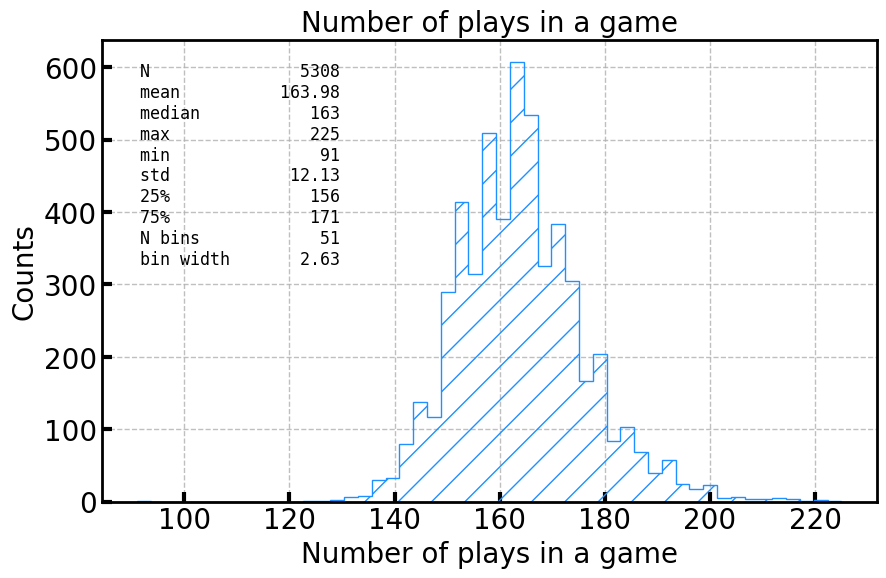

In [23]:
plotHistPlaySequences(NFLplays_split)

## LSTM model
* **input** : [circumstance, type, result]
* **output** : (new) [circumstance, type, result]  
* **padding**: sets the number of plays of each game as the maximum value of them
* **masking**: adds exception on learning, making the model skip the padded data 
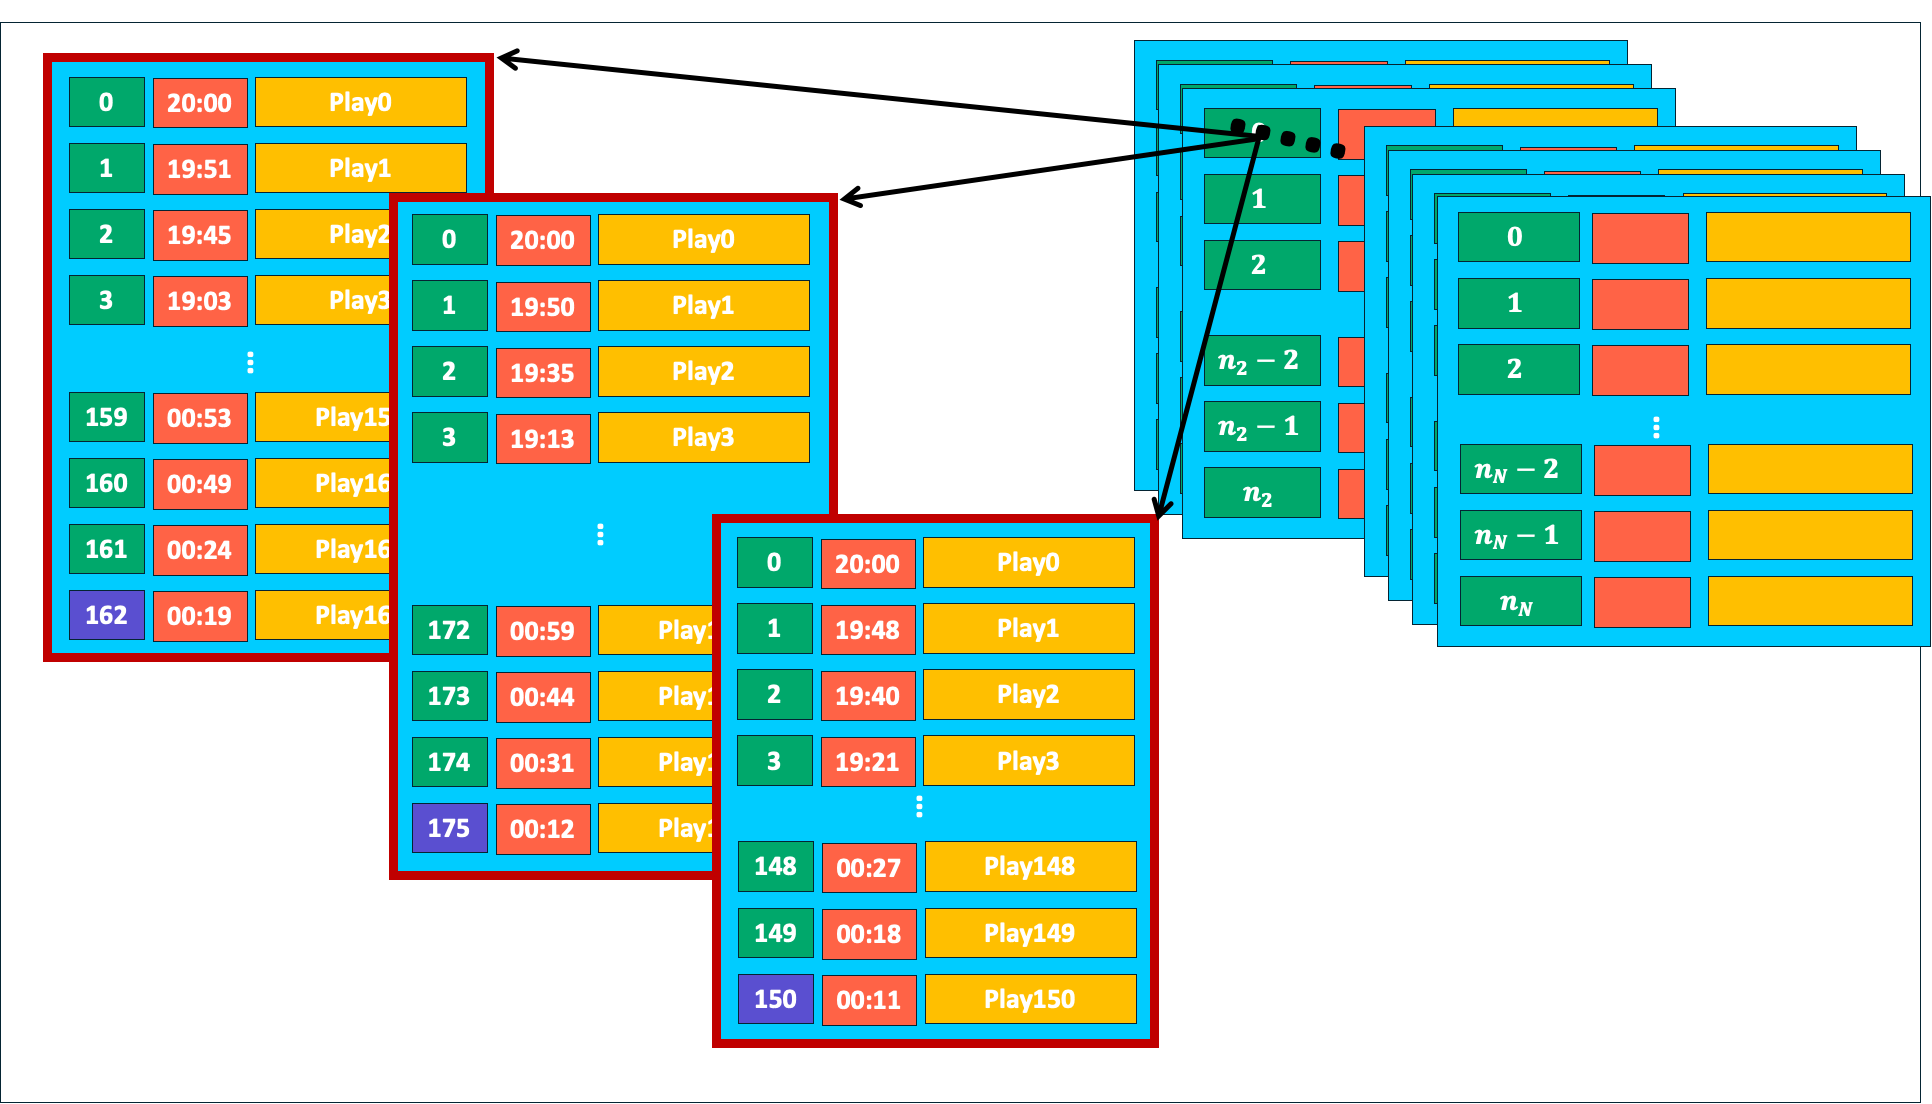

## LSTM model options
1. `return_sequences`
   * True: returns the full sequence of outputs, each element being the output of the LSTM at each time step.
   * False: returns only the last output of the sequence, a single vector, which is the output of the LSTM at the final time step
2. `loss` : the loss function
   * `categorical_crossentropy`: multi-class classification
   * `binary_crossentropy`: binary classification
   * `mse`: regression
3. `activation`: activation function
   * `softmax`: multi-class classification
   * `sigmoid`: binary classification
   * `linear`: regression
4. `metric`
   * `accuracy`, `precision`, `recall`, `f1-score` : classification
   * `mae` : regression

In [24]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, Concatenate, Input
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder

In [25]:
# def divideInputAndTarget(sequence):
#     input = sequence.iloc[:-1].values.tolist()
#     target = sequence.iloc[1:].values.tolist()
#     return input, target

In [26]:
# def buildModelCore(inputShape, hiddenUnits, Nfeatures, options):
#     input = tf.keras.Input(shape=inputShape)
#     output = Masking(mask_value=0)(input)

#     tensor = LSTM(hiddenUnits, return_sequences=True)(output)
#     tensor = Dropout(0.2)(tensor)
#     secondLayer = int(hiddenUnits/2)
#     tensor = LSTM(secondLayer, return_sequences=True)(tensor)
#     tensor = Dropout(0.2)(tensor)

#     output_C = Dense(Nfeatures, activation=options['activation'])(tensor)
#     model = tf.keras.Model(input, output_C)
#     model.compile(optimizer='adam', loss=options['loss'], metrics=[options['metrics']])

#     return model

In [27]:
# def buildModel(inputShape_C, inputShape_T, inputShape_R, hiddenUnits, options):

#     ##@ TODO combine before model core
#     input_C, output_C = buildModelCore(inputShape_C, hiddenUnits)
#     input_T, output_T = buildModelCore(inputShape_T, hiddenUnits)
#     input_R, output_R = buildModelCore(inputShape_R, hiddenUnits)
    
#     concatenated = Concatenate()([output_C, output_T, output_R])
#     output = Dense(hiddenUnits, activation=options['activation'])(concatenated)
#     model = tf.keras.Model(inputs=[input_C, input_T, input_R], outputs=output)
    
#     # Ensure metrics is a list
#     if isinstance(options['metrics'], str):
#         options['metrics'] = [options['metrics']]
    
#     model.compile(optimizer='adam', loss=options['loss'], metrics=options['metrics'])
#     return model

In [28]:
# def getPadded(sequence, maxNplays, padding_value=0):
#     padded = sequence + [[padding_value]*len(sequence[0])]*(maxNplays - len(sequence))
#     return padded

In [29]:
# def trainLSTM(NFLplays_split, options):
#     # lists of lists of dataframes 
#     circumstances = []
#     types = []
#     results = []

#     Ngames = len(NFLplays_split)
#     # the length of the longest game
#     maxNplays = max(len(game) for game in NFLplays_split)

#     for i in range(Ngames):
#         circumstances.append(pp.getCircumstance(NFLplays_split[i]))
#         types.append(pp.getPlayType(NFLplays_split[i]))
#         results.append(pp.getPlayResult(NFLplays_split[i]))

#     # lists of lists of dataframes 
#     # [[df,df,...df],[df,df,...df],...[df,df,...df]]
#     # df is a play
#     inputPad_C = []
#     inputPad_T = []
#     inputPad_R = []
#     targetPad_C = []
#     targetPad_T = []
#     targetPad_R = []


#     for i in tqdm(range(Ngames), desc="Preparing data"):
#         # these are sequences of circumstances, types, and results
#         inputCircumstance, targetCircumstance = divideInputAndTarget(circumstances[i])
#         inputType, targetType = divideInputAndTarget(types[i])
#         inputResult, targetResult = divideInputAndTarget(results[i])

#         inputPad_C.append(getPadded(inputCircumstance, maxNplays))
#         inputPad_T.append(getPadded(inputType, maxNplays))
#         inputPad_R.append(getPadded(inputResult, maxNplays))
#         targetPad_C.append(getPadded(targetCircumstance, maxNplays))
#         targetPad_T.append(getPadded(targetType, maxNplays))
#         targetPad_R.append(getPadded(targetResult, maxNplays))

#     Nfearues_C = len(inputPad_C[0][0])
#     Nfearues_T = len(inputPad_T[0][0])
#     Nfearues_R = len(inputPad_R[0][0])

#     # the number of games, the number of plays in the longest game, the number of features    
#     print(f'inputPad_C: {len(inputPad_C), len(inputPad_C[0]), Nfearues_C}')
#     print(f'inputPad_T: {len(inputPad_T), len(inputPad_T[0]), Nfearues_T}')
#     print(f'inputPad_R: {len(inputPad_R), len(inputPad_R[0]), Nfearues_R}')

#     print(f'output_C: {len(targetPad_C), len(targetPad_C[0]), len(targetPad_C[0][0])}')
#     print(f'output_T: {len(targetPad_T), len(targetPad_T[0]), len(targetPad_T[0][0])}')
#     print(f'output_R: {len(targetPad_R), len(targetPad_R[0]), len(targetPad_R[0][0])}')

#     inputShape_C = (maxNplays, Nfearues_C)
#     inputShape_T = (maxNplays, Nfearues_T)
#     inputShape_R = (maxNplays, Nfearues_R)

#     hiddenUnits = 128  # common practice
#     defaultBatchSize = 32

#     # # what should be the output? circumstances?
#     outputShape = inputShape_C

#     # model = buildModel(inputShape_C, inputShape_T, inputShape_R, hiddenUnits, options)
#     model = buildModelCore(inputShape_C, hiddenUnits, Nfearues_C, options)
#     model.fit(inputPad_C, 
#               outputShape, 
#               epochs=10, 
#               batch_size=defaultBatchSize,
#               validation_split=0.2)

#     # # @TODO: KFold cross validation
#     # # @TODO: hyperparameter tuning
#     # model.save('../LSTM/prototypeModel_310524.h5')
    
#     return model

|	|Number of Games	|Number of Plays in Longest Game	|Number of Features|
|-|-|-|-|
|inputPad_C |5308	|225	|14|
|inputPad_T	|5308	|225	|4|
|inputPad_R	|5308	|225	|6|

In [30]:
# model = trainLSTM(debugTrain, getOptions(False))
# > 452 min : 7 hr 32 min
# > 932 min : 15 hr 32 min
# > 1143 min : 19 hr 3 min

In [31]:
print(f'Number of possession teams: {len(NFLplays["possessionTeamId"].unique())}')
print(f'Number of nonpossession teams: {len(NFLplays["nonpossessionTeamId"].unique())}')

Number of possession teams: 32
Number of nonpossession teams: 32


* we need to figure out how to describe the data we use.

* play types: visualise some important of these play types
    kickoff 0
    pass 1
    penalty 2
    field goal 3
    rush 4
    punt 5
    xp 6
    spike 7
    kneel 8
    aborted 9
    two-point 10

* visualisation:
  * overview ground configuration:
  * some play types:

## What is RNN (Recurrent Neural Network)? - TOP DOWN, 
(profread by ChatGPT)

### General Aspects of NN

* **Forward Pass**
  * The input data is passed through the network layers to generate an output.
  * The output is compared to the target values using the loss function.
  
* **Loss Function ($ \mathcal{L} $)**: Indicator of how well the network predicts
  * Calculates the error between the prediction and the true value.
  * Common examples: MSE (Mean Squared Error) for regression or Cross-Entropy Loss for classification.

* **Backpropagation**
  * The error is propagated backward through the network.
  * Computes $( \frac{\partial \mathcal{L}}{\partial \theta} )$, the gradient of the loss function with respect to the parameters.
    * This represents the sensitivity of $( \mathcal{L} )$ with respect to the parameters.

* **Gradient Descent**
  * Updates the parameters in a direction that reduces the loss.
  * Uses optimisation algorithms like SGD (Stochastic Gradient Descent).

### Why RNN (LSTM, GRU)?

* To minimise $( \mathcal{L} )$, find the gradient of the loss function with respect to the parameters.
* A solution for the **vanishing gradient problem** of traditional NNs, which typically emerges during deep iterations or in networks handling long sequences.

> ##### What is the Vanishing Gradient Problem?
> * In NNs, the gradients of $( \mathcal{L} )$ with respect to the parameters are multiplied by the weights.
> * If the weights are small, the gradients diminish exponentially as they are propagated.
> * This is problematic for learning long-term dependencies.

* Solutions to this problem include LSTM (Long Short-Term Memory) or GRU (Gated Recurrent Unit).


In [32]:
def getOptions(isClassification):
    classification = {
        'return_sequences': True,
        'loss': 'categorical_crossentropy',
        'activation': 'softmax',
        'metrics': 'accuracy',
    }
    regression = {
        'return_sequences': True,
        'loss': 'mse',
        'activation': 'relu',
        'metrics': 'mae',
    }
    if isClassification:
        options = classification
    else:
        options = regression
    return options

In [33]:
def LSTMtest():
    inputs = np.random.random((32, 10, 8))
    lstm = LSTM(4)
    output = lstm(inputs)
    print(f'output shape: {output.shape}')
    
    lstm = LSTM(4, return_sequences=True, return_state=True)
    whole_seq_output, final_memory_state, final_carry_state = lstm(inputs)
    print(f'whole_seq_output shape: {whole_seq_output.shape}')
    print(f'final_memory_state shape: {final_memory_state.shape}')
    print(f'final_carry_state shape: {final_carry_state.shape}')
LSTMtest()


output shape: (32, 4)
whole_seq_output shape: (32, 10, 4)
final_memory_state shape: (32, 4)
final_carry_state shape: (32, 4)


In [34]:
def divideInputAndTarget(sequence):
    input_seq = sequence[:-1]
    target_seq = sequence[1:]
    return np.array(input_seq), np.array(target_seq)

In [35]:
def getPaddedSequence(sequence, maxNplays, padding_value=0):
    padded = np.full((maxNplays, len(sequence[0])), padding_value)
    padded[:len(sequence)] = sequence
    return padded

def getPaddedTarget(sequence, maxNplays, padding_value=0):
    padded = np.full(maxNplays, padding_value)
    padded[:len(sequence)] = sequence
    return padded

### Notes about `units` in `keras.layer.LSTM`(it is the **level of complexity**)
* each LSTM layer maintains its own cell state and output
* `units` is the number of the memory cells in the layer
* small vs large
  * small: may not capture the complexity of the data, leading to underfitting.
  * large: can lead to overfitting, where the model performs well on training data but poorly on unseen data
* large data size: can typically support a more complex model with more units.

### Notes about `batch_size` in `model.fit`
* it determines how many games are passed through the network before updating the model's weights.
* `batch_size = 32`: the model processes 32 games at a time before performing a backpropagation step and updating the weights.
* Smaller batch sizes can provide more stable convergence but may take longer per epoch.
* For the sake of memory access patterns, use powers of 2
  * For larger datasets, batch sizes of 64, 128, or even 256 can be effective.

In [36]:
def buildLSTMCore(Nunits, Nfeatures, Ntypes, Nresults, options):
    inputs = Input(shape=(None, Nfeatures))
    x = Masking(mask_value=0)(inputs)
    x = LSTM(units=Nunits, 
              input_shape=(None, Nfeatures), 
              activation=options['activation'], 
              return_sequences=options['return_sequences'])(x)
    ouput_playType = Dense(Ntypes, activation=options['activation'], name = 'playType')(x)
    ouput_playResult = Dense(Nresults, activation=options['activation'], name = 'playResult')(x)
    model = Model(inputs=inputs, outputs=[ouput_playType, ouput_playResult])
    model.summary()
    model.compile(optimizer='adam', 
                  loss = {'playType': options['loss'], 
                          'playResult': options['loss']},
                  metrics = {'playType': options['metrics'], 
                             'playResult': options['metrics']}
                    )
    return model

In [37]:
def trainLSTM(NFLplays_split_train, fileName, isDebug=False):
    # ------------ tuning parameters
    Nunits = 100
    Nbatch = 128
    # ------------

    options = getOptions(isClassification=True)

    Ngames = len(NFLplays_split_train)
    maxNplays = max(len(game) for game in NFLplays_split_train)
    Ntypes = NFLplays['playType'].nunique()
    Nresults = NFLplays['playResult'].nunique()
    Nfeatures = len(pp.getColumns('playCircumstance'))

    if isDebug:
        print(f"Ntypes (playType classes): {Ntypes}")
        print(f"Nresults (playResult classes): {Nresults}")

    model = buildLSTMCore(Nunits, Nfeatures, Ntypes, Nresults, options)

    X_train = []
    y_playType_train = []
    y_playResult_train = []

    for game in tqdm(NFLplays_split_train, desc="Preparing data"):
        inputSequence = []
        targetSequence_playType = []
        targetSequence_playResult = []

        for index, play in game.iterrows():
            inputSequence.append(pp.getCircumstance(play).values)
            targetSequence_playType.append(play['playType'])
            targetSequence_playResult.append(play['playResult'])

        X_train.append(getPaddedSequence(inputSequence, maxNplays))
        y_playType_train.append(getPaddedTarget(targetSequence_playType, maxNplays))
        y_playResult_train.append(getPaddedTarget(targetSequence_playResult, maxNplays))

    X_train = np.array(X_train)
    y_playType_train = np.array(y_playType_train)
    y_playResult_train = np.array(y_playResult_train)

    # unknown playType temporarily set to 0
    y_playResult_train[y_playResult_train < 0] = 0

    encoder_playType = OneHotEncoder(sparse_output=False)
    y_playType_train = encoder_playType.fit_transform(y_playType_train.reshape(-1, 1)).reshape(X_train.shape[0], maxNplays, -1)
    
    encoder_playResult = OneHotEncoder(sparse_output=False, categories=[range(Nresults)])
    y_playResult_train = encoder_playResult.fit_transform(y_playResult_train.reshape(-1, 1)).reshape(X_train.shape[0], maxNplays, -1)

    if isDebug:
        print(f"X_train shape: {X_train.shape}")
        print(f"y_playType_train shape: {y_playType_train.shape}")
        print(f"y_playResult_train shape: {y_playResult_train.shape}")
        print(f"Unique classes in playType: {encoder_playType.categories_}")
        print(f"Unique classes in playResult: {encoder_playResult.categories_}")
        print(f"Keys in training data dictionary: {list({'playType': y_playType_train, 'playResult': y_playResult_train}.keys())}")
        print(f"Model output names: {model.output_names}")

    model.fit(X_train,
              {'playType': y_playType_train, 'playResult': y_playResult_train},
              epochs=10,
              batch_size=Nbatch,
              validation_split=0.2)
    dirPath = '../LSTM/'
    model.save(dirPath+fileName)
    return model

In [38]:
debugTrain, debugTest = pp.separateTrainTest(NFLplays_split, test_size=0.9)
print(f'Number of games in the training set: {len(debugTrain)}')
print(f'Number of games in the test set: {len(debugTest)}')

Number of games in the training set: 531
Number of games in the test set: 4777


In [39]:
print(f'NFLplays circumstance columns: {len(pp.getCircumstance(NFLplays_split[0]).columns)}')
print(f'NFLplays playType columns: {len(pp.getPlayType(NFLplays_split[0]).columns)}')
print(f'NFLplays results columns: {len(pp.getPlayResult(NFLplays_split[0]).columns)}')

NFLplays circumstance columns: 13
NFLplays playType columns: 3
NFLplays results columns: 5


In [40]:
model = trainLSTM(debugTrain, 'prototypeModel_040624_10.h5', isDebug=True)
# 0.9 : 1 min 30 sec

Ntypes (playType classes): 11
Nresults (playResult classes): 26
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, 13)]           0         []                            
                                                                                                  
 masking (Masking)           (None, None, 13)             0         ['input_1[0][0]']             
                                                                                                  
 lstm_2 (LSTM)               (None, None, 100)            45600     ['masking[0][0]']             
                                                                                                  
 playType (Dense)            (None, None, 11)             1111      ['lstm_2[0][0]']              
                              

Preparing data: 100%|██████████| 531/531 [00:47<00:00, 11.29it/s]


X_train shape: (531, 214, 13)
y_playType_train shape: (531, 214, 11)
y_playResult_train shape: (531, 214, 26)
Unique classes in playType: [array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])]
Unique classes in playResult: [array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25])]
Keys in training data dictionary: ['playType', 'playResult']
Model output names: ['playType', 'playResult']
Epoch 1/10
4/4 [==============================] - 5s 650ms/step - loss: 5.6554 - playType_loss: 2.3974 - playResult_loss: 3.2580 - playType_accuracy: 0.0580 - playResult_accuracy: 0.0692 - val_loss: 5.6435 - val_playType_loss: 2.3915 - val_playResult_loss: 3.2520 - val_playType_accuracy: 0.4024 - val_playResult_accuracy: 0.0925
Epoch 2/10
4/4 [==============================] - 2s 598ms/step - loss: 5.6378 - playType_loss: 2.3892 - playResult_loss: 3.2486 - playType_accuracy: 0.4311 - playResult_accuracy: 0.1161 - val_loss: 5.6267 - val_playTyp

/usr/local/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [41]:
def loadModel(fileName):
    dirPath = '../LSTM/'
    load_model(dirPath+fileName)
    return model

In [42]:
model = loadModel('prototypeModel_040624_10.h5')

In [111]:
def buildDF(actual_playType, actual_playResult, predicted_playType, predicted_playResult):
    print(f'actual_playType: {actual_playType.shape}')
    print(f'actual_playResult: {actual_playResult.shape}')
    print(f'predicted_playType: {predicted_playType.shape}')
    print(f'predicted_playResult: {predicted_playResult.shape}')
    
    # Convert arrays to float type to handle np.nan
    actual_playType = actual_playType.astype(float)
    actual_playResult = actual_playResult.astype(float)
    predicted_playType = predicted_playType.astype(float)
    predicted_playResult = predicted_playResult.astype(float)
    
    # Determine the maximum length
    max_length = max(len(actual_playType), len(predicted_playType), len(actual_playResult), len(predicted_playResult))
    
    # Pad the arrays to the maximum length
    actual_playType_padded = np.pad(actual_playType, (0, max_length - len(actual_playType)), constant_values=np.nan)
    predicted_playType_padded = np.pad(predicted_playType, (0, max_length - len(predicted_playType)), constant_values=np.nan)
    
    actual_playResult_padded = np.pad(actual_playResult, (0, max_length - len(actual_playResult)), constant_values=np.nan)
    predicted_playResult_padded = np.pad(predicted_playResult, (0, max_length - len(predicted_playResult)), constant_values=np.nan)
    
    # Create DataFrame for playType and playResult
    playTypeDf = pd.DataFrame({'Actual': actual_playType_padded, 'Predicted': predicted_playType_padded})
    playResultDf = pd.DataFrame({'Actual': actual_playResult_padded, 'Predicted': predicted_playResult_padded})
    
    return playTypeDf, playResultDf

In [105]:
def predictLSTM(model, testGame, Nplays, isDebug=False):
    inputSequence = np.array([pp.getCircumstance(play).values for index, play in testGame.iterrows()])
    inputSequence = np.expand_dims(inputSequence, axis=0)

    if isDebug:
        print(f'Initial inputSequence shape: {inputSequence.shape}')

    predicted_playType = []
    predicted_playResult = []

    current_input = inputSequence

    for i in range(Nplays):
        predictions = model.predict(current_input, verbose=0)
        playType_pred = np.argmax(predictions[0], axis=-1).flatten()[-1]
        playResult_pred = np.argmax(predictions[1], axis=-1).flatten()[-1]

        predicted_playType.append(playType_pred)
        predicted_playResult.append(playResult_pred)

        # Prepare the next input by appending the latest prediction
        new_play = np.zeros((1, 1, current_input.shape[2]))
        new_play[0, 0, 0] = playType_pred
        new_play[0, 0, 1] = playResult_pred

        current_input = np.concatenate([current_input[:, 1:, :], new_play], axis=1)

    predicted_playType = np.array(predicted_playType)
    predicted_playResult = np.array(predicted_playResult)

    actual_playType = testGame['playType'].values
    actual_playResult = testGame['playResult'].values

    return buildDF(actual_playType, actual_playResult, predicted_playType, predicted_playResult)


In [112]:
# predictLSTM(model, debugTest[0], 20, isDebug=True)
playTypeDf_0, playResultDf_0 = predictLSTM(model, debugTest[0], 20, isDebug=True)


Initial inputSequence shape: (1, 168, 13)
actual_playType: (168,)
actual_playResult: (168,)
predicted_playType: (20,)
predicted_playResult: (20,)


In [113]:
print(f'playTypeDf_0: {playTypeDf_0.shape}')
print(f'playResultDf_0: {playResultDf_0.shape}')

playTypeDf_0: (168, 2)
playResultDf_0: (168, 2)


In [114]:
playTypeDf_0.head()

,Actual,Predicted
0,0.0,1.0
1,1.0,1.0
2,2.0,1.0
3,4.0,1.0
4,4.0,1.0


In [115]:
playResultDf_0.head()

,Actual,Predicted
0,0.0,0.0
1,1.0,0.0
2,-1.0,0.0
3,5.0,0.0
4,4.0,0.0


## Discussions
* The prediction chain is not complete, I just see one example. 
* I made a model and saved using 0.1 of the total games
  * it took less than 1 min 30sec even on my laptop so we can try more
* #### **TODO**: handle the `unknown` class of playResult. 
  * I temporarily made all of them in 0, but we surely have to change them
* #### **TODO** : make a prediction model for **the number of the plays for a game** given its values. 
  * instead of padding the input data to set the size during the model training, 
  * I currently set the number of the plays of each game as another free variable.
  * which might make sense as the Nplays should also (normally) different from the actual to prediction.
  * I believe we can cover this easily by using mighty XGB
